# Semantic Segmentation Using U-Net
### Artificial Intelligence Course | Instructed by DR. MohammadHossein Rohban
<font color='cyan'> Responsible TAs: Amirhossein Razlighi, Reza Vahidimajd </font>

<font color='yellow'> Please ask your questions via [Quera](www.quera.com) </font>

**Group: HI**

| Name                  | Student ID |
|-----------------------|------------|
| Armin Khosravi        | 401105872  |
| Alireza Malekhosseini | 401106566  |
| Shayan Baghayi Nejad  | 401105718  |


In this excercise, you will design and train a CNN-based network called U-Net. This type of networks are used for semantic segmentation. This task is, as it's called, segmenting the image, semantically to different parts. You can consider this as a classification, done on each pixel of the image! Below, you can see an example of the task:


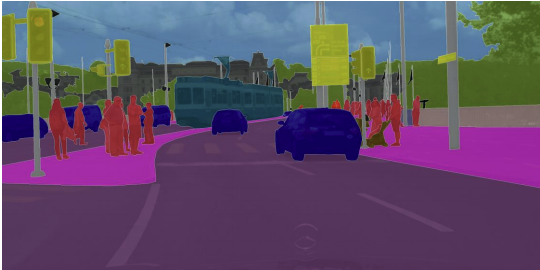 <br>
Example of a segmented image <br>


We will use a dataset which is used for "Self-Driving Car" Purposes. As you may know, understanding each pixel (in the view point of car) is an important task for self-driving cars. Let's proceed with this task to the end of this excercise!

## Downloading Dataset

In [ ]:
%pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

In [ ]:
!unzip Files.zip

In [1]:
%pip install --upgrade --ignore-installed --user torch torchvision torchsummary

^C
Note: you may need to restart the kernel to use updated packages.


<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader , random_split
from PIL import Image
import torch.optim as optim
import os
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

%matplotlib inline

### Set torch device to appropriate type for GPU training

In [3]:
print(torch.cuda.is_available())
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
)
device

True


device(type='cuda')

<a name='2'></a>
## 2 - Load the Data

In [39]:
path = "" # Path to the root folder
image_path = os.path.join(path, "Files/data/CameraRGB/")
mask_path = os.path.join(path, "Files/data/CameraMask/")
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=5`

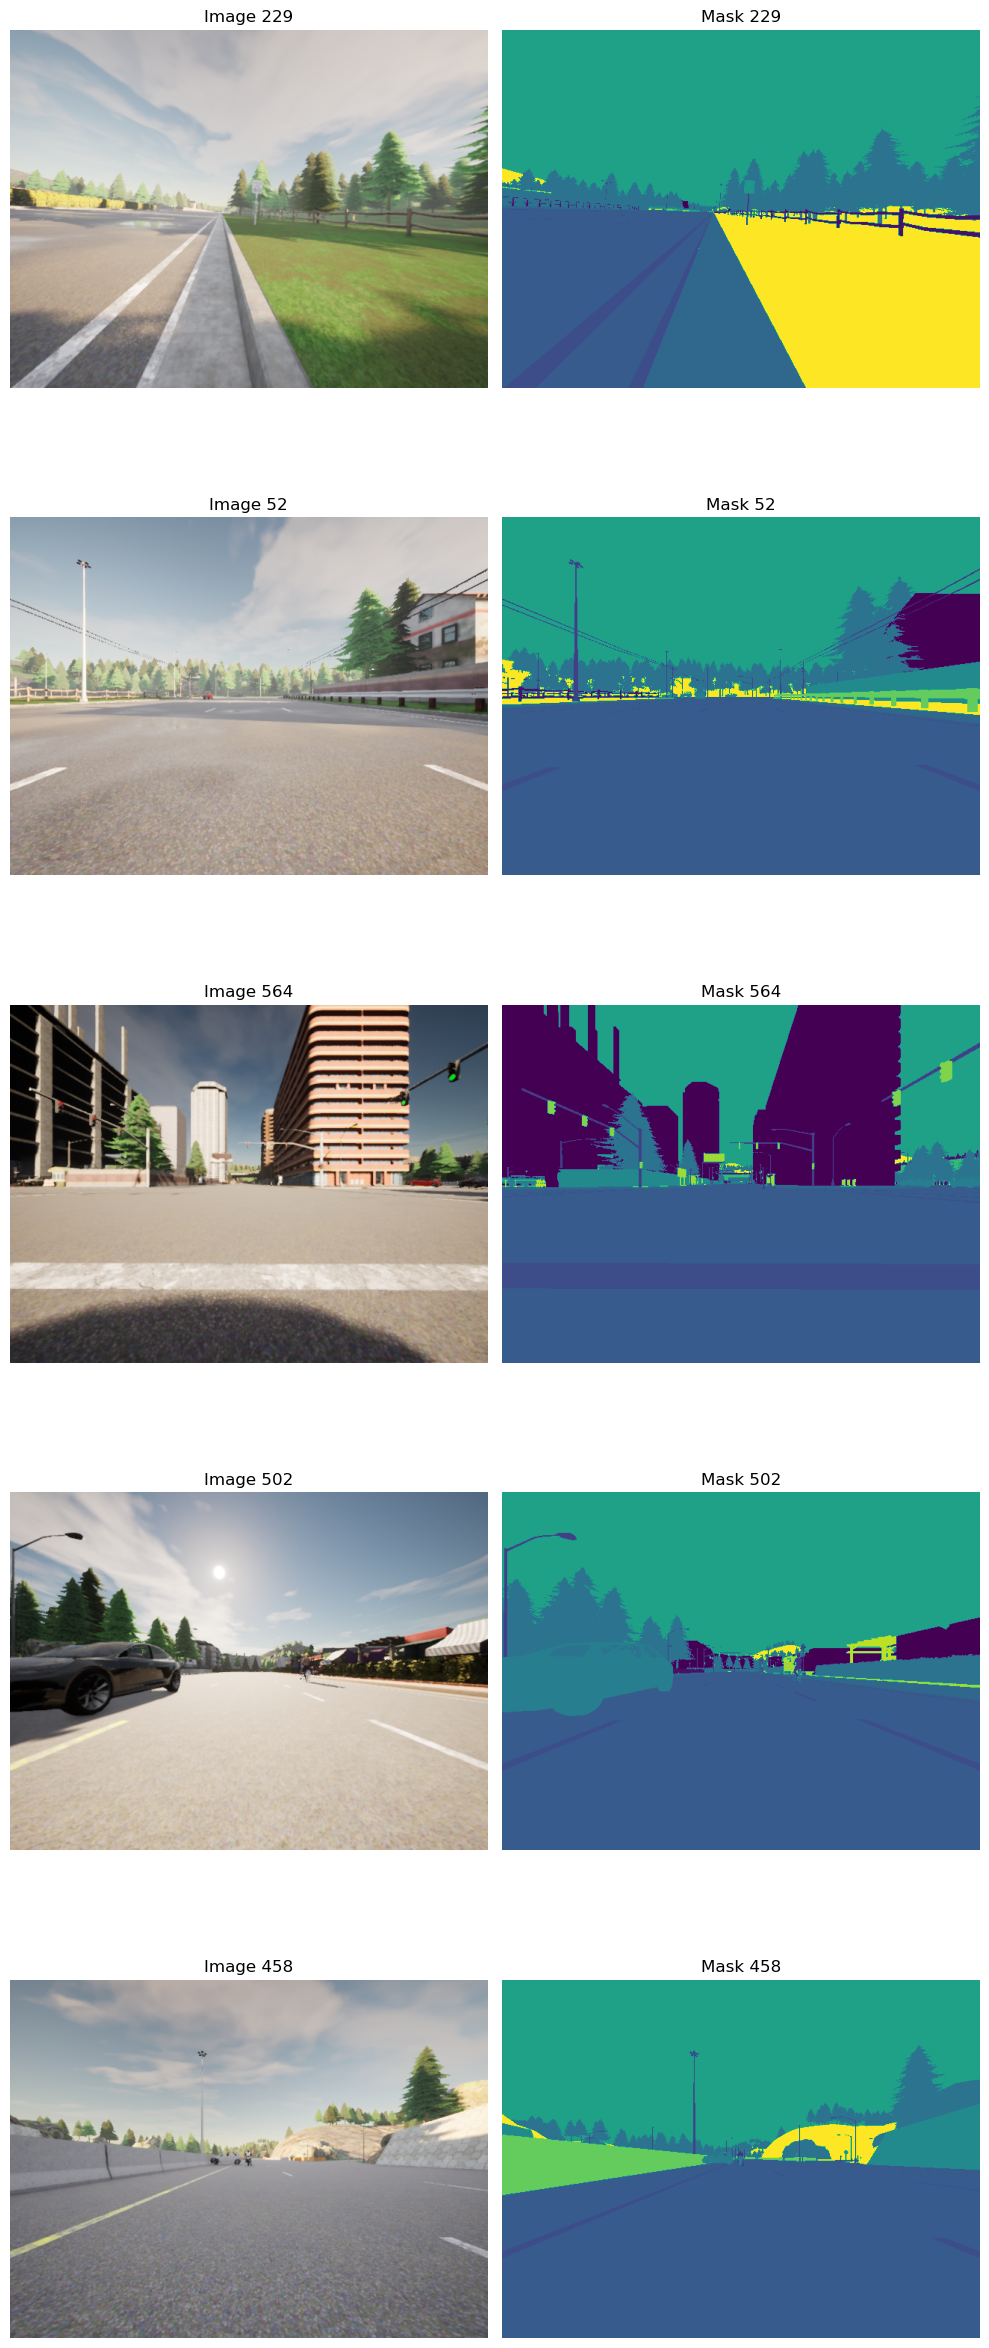

In [40]:

# Number of images to display
N = 5

random.seed(42)

# Select N random indices
random_indices = random.sample(range(len(image_list)), N)

fig, axes = plt.subplots(N, 2, figsize=(10, 5 * N))

for i, idx in enumerate(random_indices):
    img = mpimg.imread(image_list[idx])
    mask = mpimg.imread(mask_list[idx])

    # Display the image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image {idx + 1}")
    axes[i, 0].axis('off')

    # Display the mask
    axes[i, 1].imshow(mask[:, :, 0])
    axes[i, 1].set_title(f"Mask {idx + 1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


<a name='2-2'></a>
### 2.2 - Preprocess Your Data



In [6]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory="Files/data/CameraRGB/", MasksDirectory="Files/data/CameraMask/"):
        #TODO: Do anything necessary to initialize the object
        # ...
        path = ""  # Path to the root folder
        self.image_path = os.path.join(path, ImagesDirectory)
        self.mask_path = os.path.join(path, MasksDirectory)
        self.image_list = sorted(os.listdir(self.image_path))
        self.mask_list = sorted(os.listdir(self.mask_path))
        self.image_list = [self.image_path + i for i in self.image_list]
        self.mask_list = [self.mask_path + i for i in self.mask_list]

        # TODO: Define the mask transforms
        # Your transform should contain: Resizing to 192x256 (and any more things you want to add!)
        self.mask_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256), interpolation=Image.NEAREST),
                transforms.ToTensor(),
                lambda mask: mask[0],
                lambda mask: (255 * mask).type(torch.LongTensor)
            ]
        )
        # TODO: Define the image transforms
        # Your transform should contain: Transforming to PIL image format, resizing to 192x256,
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x[:3, :, :])  # Ensure only first 3 channels are selected
            ]
        )

    def __len__(self):
        # TODO
        return len(self.image_list)

    def __getitem__(self, index):
        # TODO
        # Get the image and mask paths
        image_path = self.image_list[index]
        mask_path = self.mask_list[index]

        # Open the image and mask using PIL
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale
        # mask = Image.open(mask_path)

        # Apply the transforms
        image = self.image_transforms(image)
        mask = self.mask_transforms(mask)

        # Return the image and mask as a tuple
        return image, mask




<a name='2-3'></a>
### 2.3 - Hyper-parameters and Optimizer

In [7]:
# TODO
EPOCHS = 10
BATCH_SIZE = 16
LR = 5e-4
B1 = 0.85
B2 = 0.99

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

You will see the transpose convolution referred to by several names, including "deconvolution" and "upconvolution", but these are all the same thing. You will also see the model's architecture in the following cells.


<a name='3-1'></a>
### 3.1 - Model Details

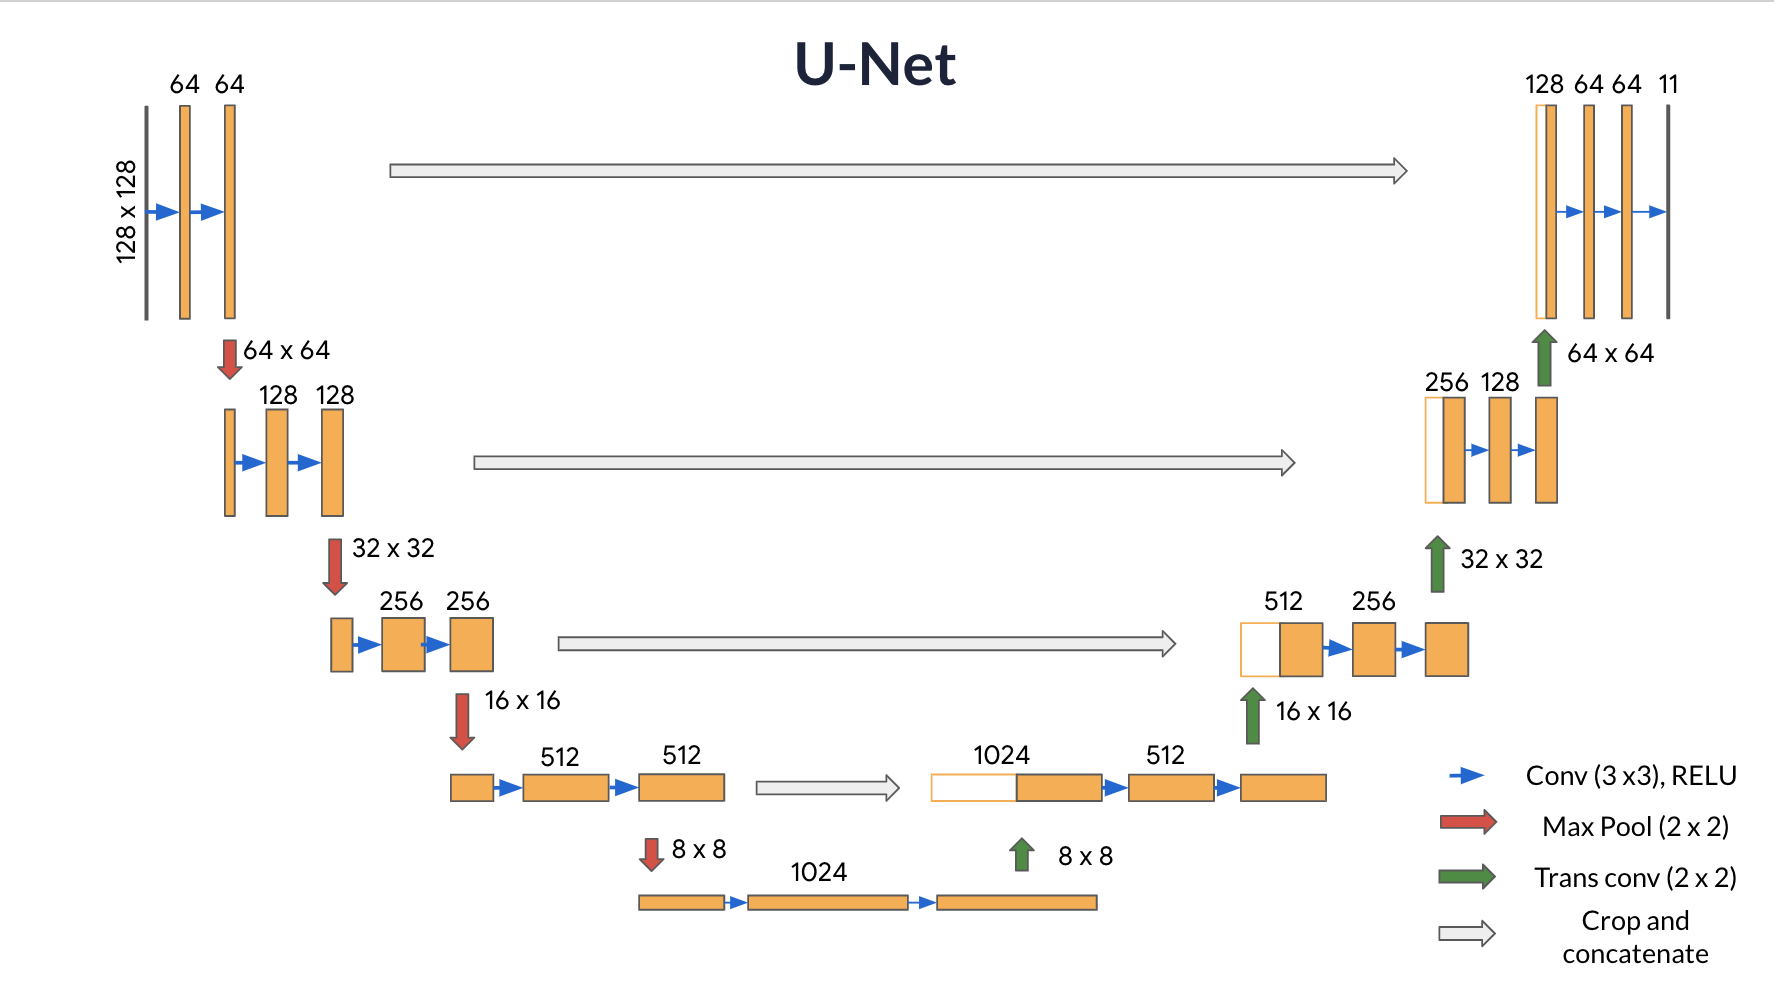<br>
U-Net Architecture<br>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

**Important Note:**
The figures shown in the assignment for the U-Net architecture depict the layer dimensions and filter sizes as per the original paper on U-Net with smaller images. However, due to computational constraints for this assignment, you will code only half of those filters. The purpose of showing you the original dimensions is to give you the flavour of the original U-Net architecture. The important takeaway is that you multiply by 2 the number of filters used in the previous step. The notebook includes all of the necessary instructions and hints to help you code the U-Net architecture needed for this assignment.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

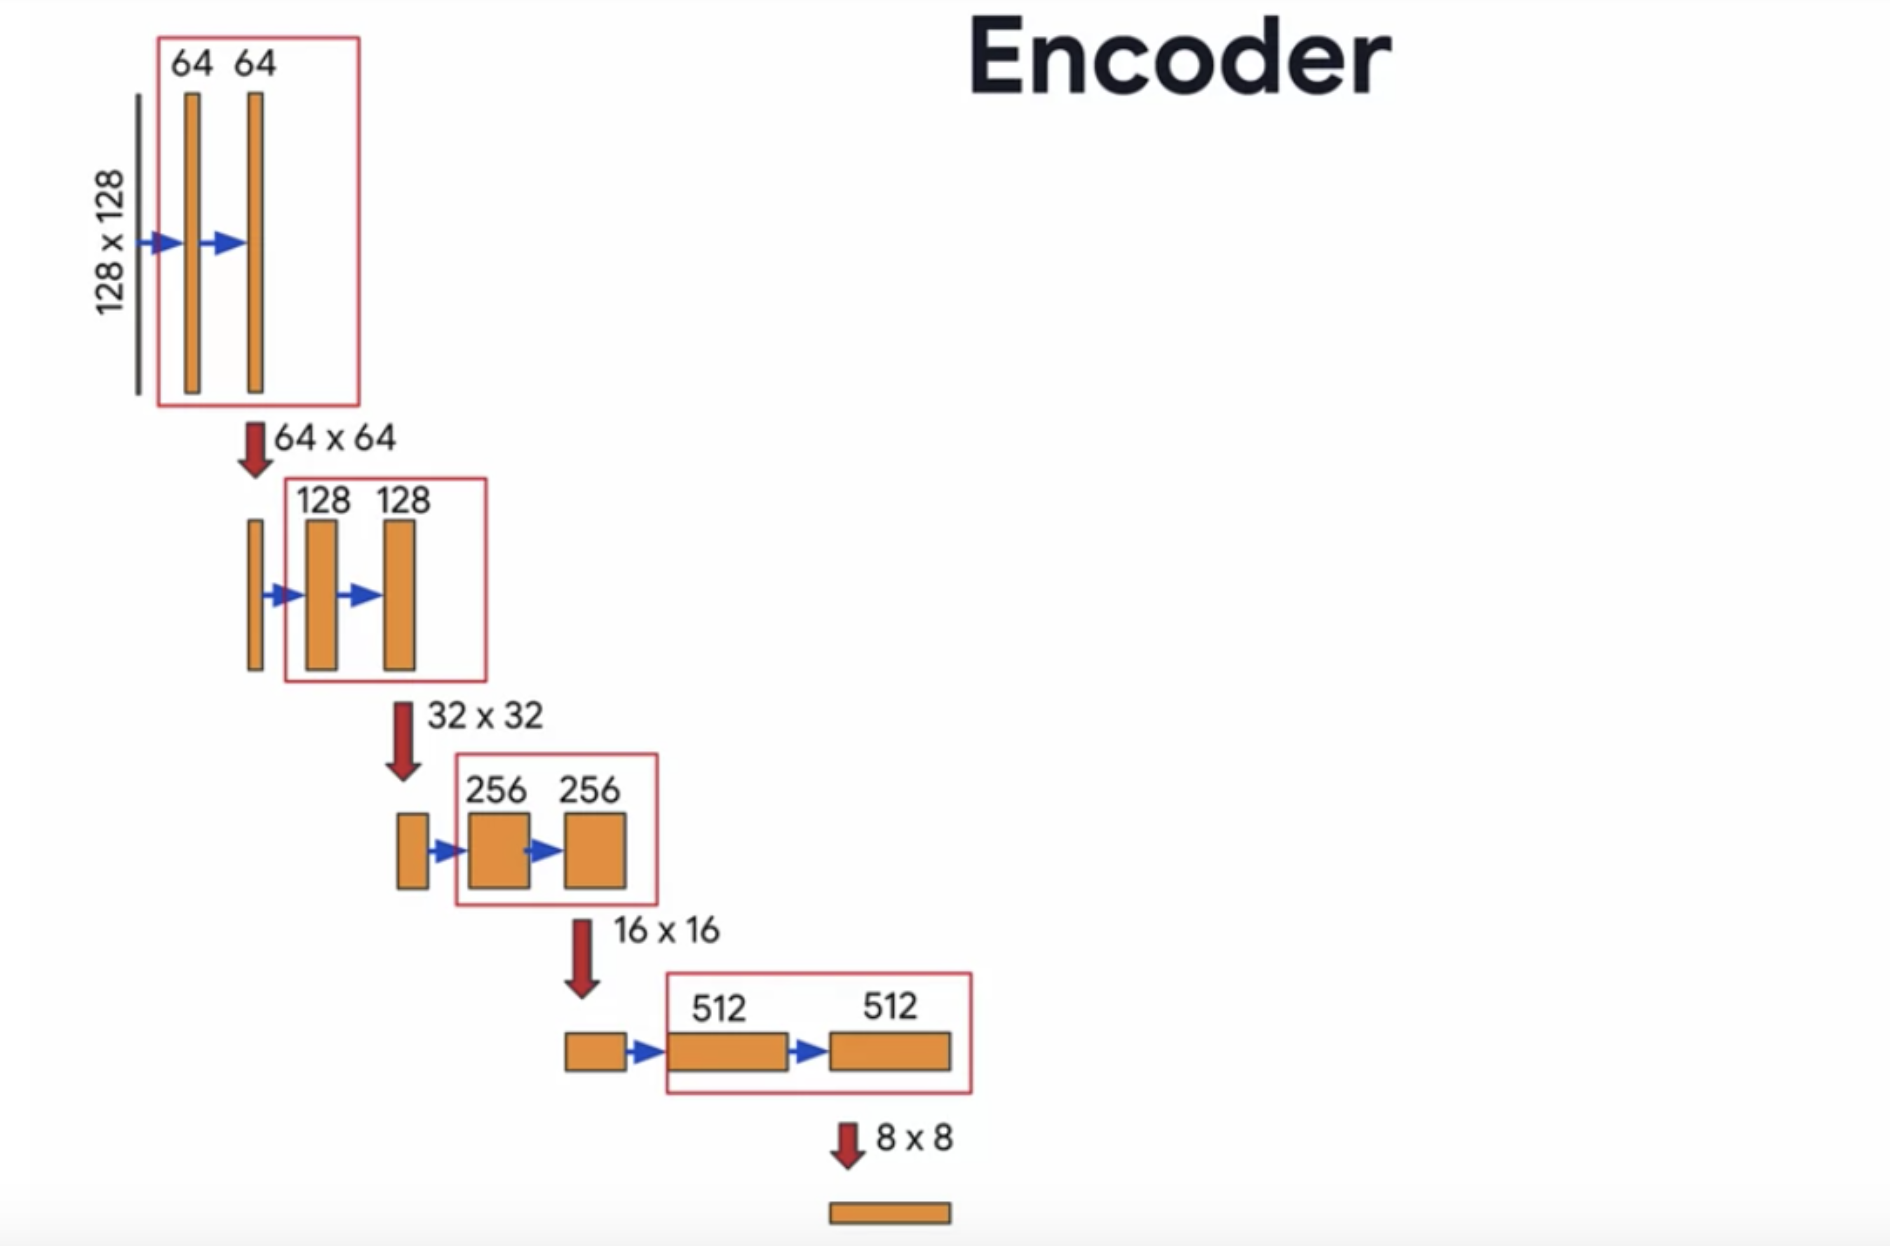<br>
The U-Net Encoder up close <br>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling.

The function will  return two tensors:
- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Initialize the DoubleConv module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super(DoubleConv, self).__init__()
        # Define a double convolutional layer with batch normalization and ReLU activation
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        """
        Forward pass for DoubleConv.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_channels, height, width).
        """
        return self.conv(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        """
        Initialize the DownSample module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            dropout_prob (float): Probability of dropping out a unit (default is 0.0, meaning no dropout).
        """
        super().__init__()
        # Apply double convolution followed by max pooling
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Apply dropout if dropout_prob > 0, else apply identity (no-op)
        self.dropout = nn.Dropout(p=dropout_prob) if dropout_prob > 0 else nn.Identity()

    def forward(self, x):
        """
        Forward pass for DownSample.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).

        Returns:
            tuple: Tuple containing:
                - conv_output (torch.Tensor): Output tensor after convolution of shape (batch_size, out_channels, height, width).
                - pooled_output (torch.Tensor): Output tensor after pooling and dropout of shape (batch_size, out_channels, height/2, width/2).
        """
        conv_output = self.conv(x)
        pooled_output = self.pool(conv_output)
        pooled_output = self.dropout(pooled_output)
        return conv_output, pooled_output


<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

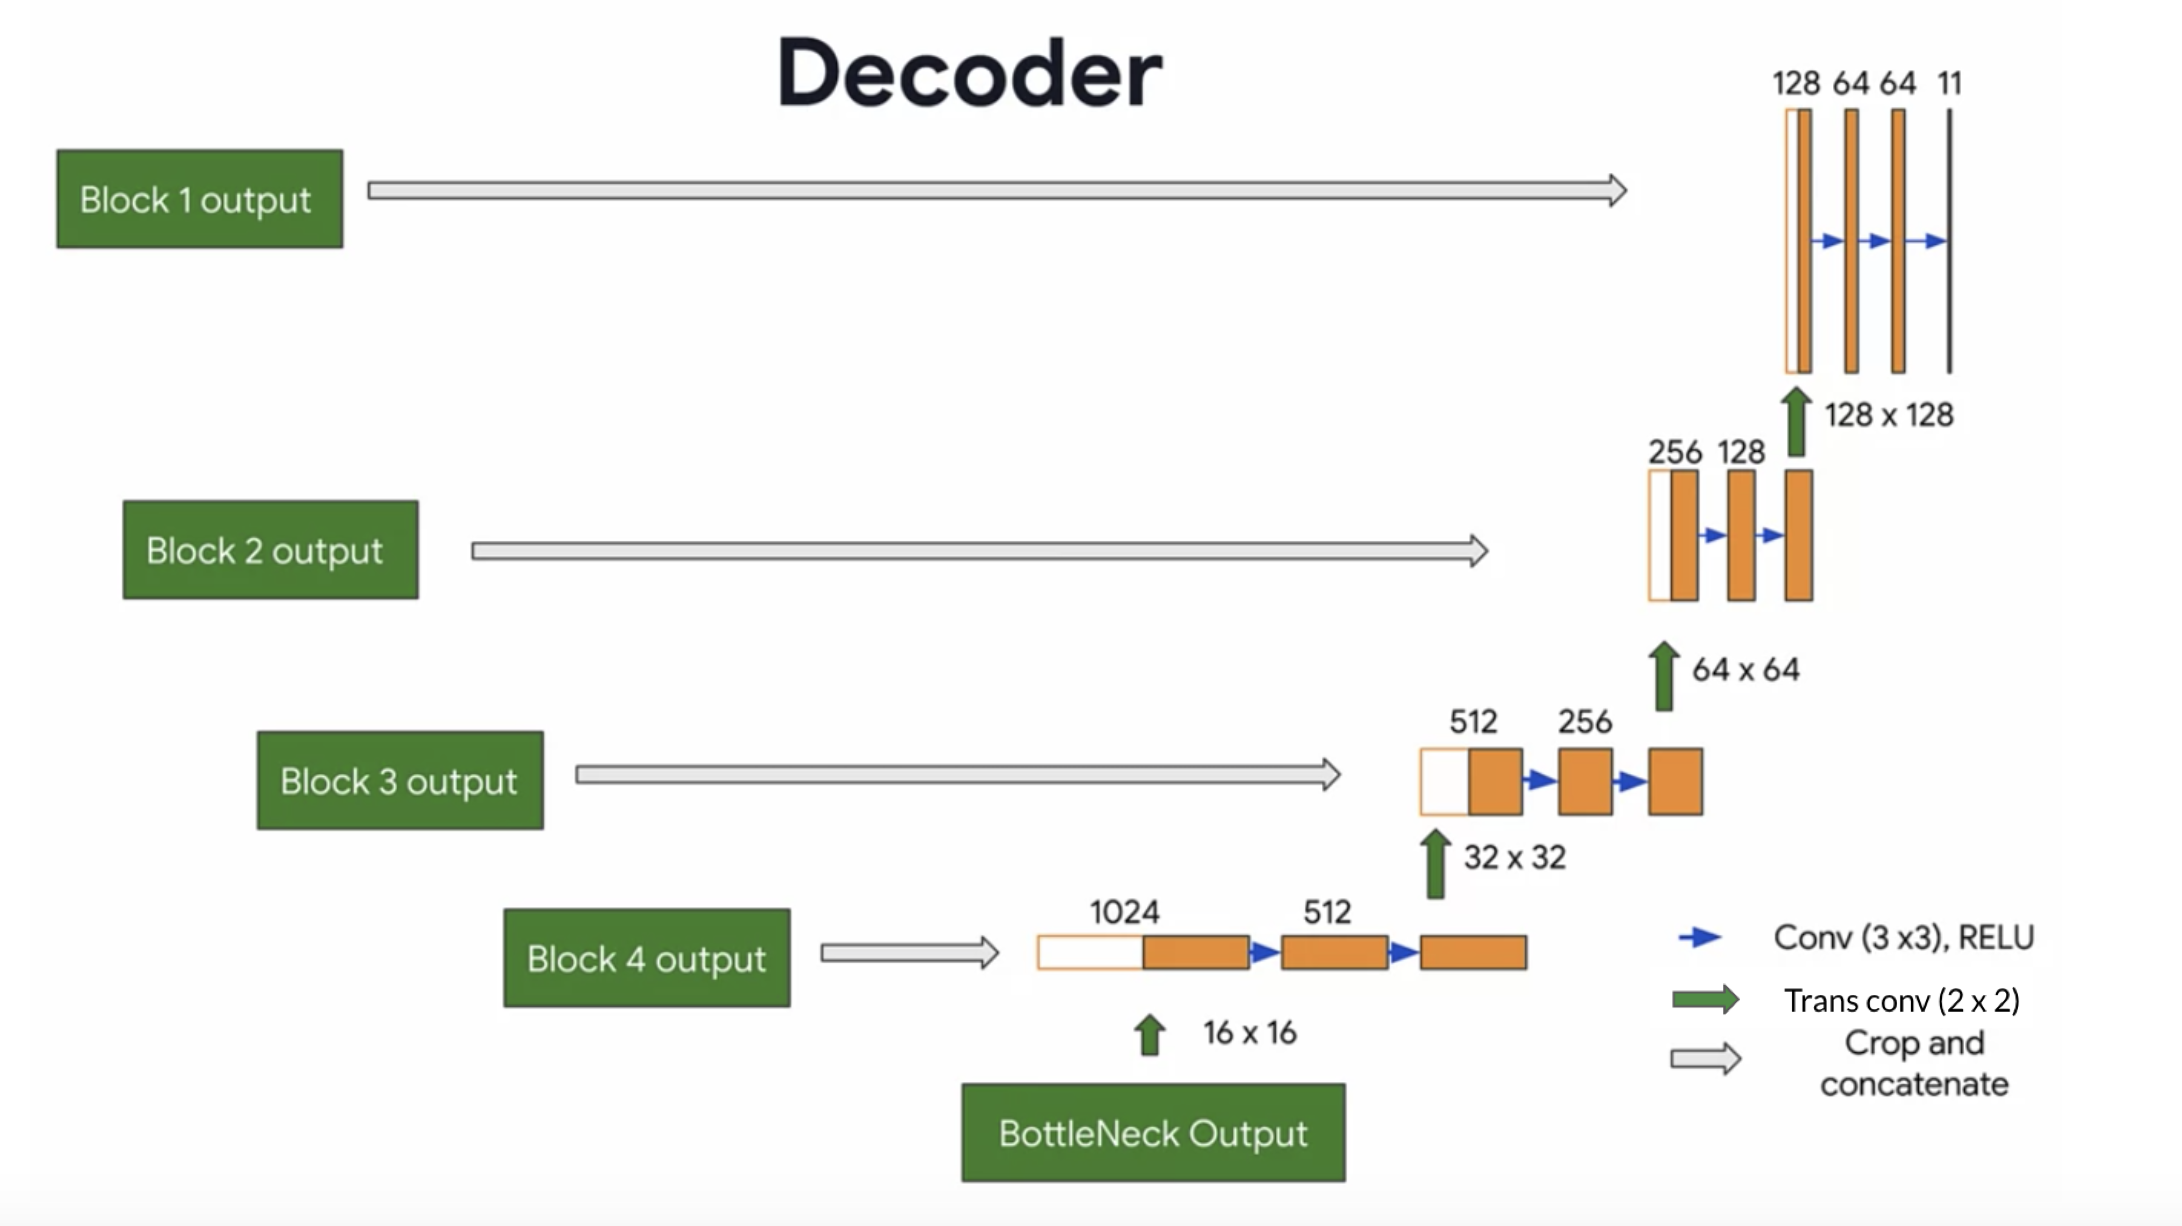<br>
The U-Net Decoder up close <br>

There are two new components in the decoder: `up` and `cat`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.

Here you'll encounter the `ConvTranspose2d` layer, which performs the inverse of the `Conv2d` layer.



In [9]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Initialize the UpSample module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super().__init__()
        # Define a transposed convolutional layer for upsampling
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        # Apply double convolution
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        Forward pass for UpSample.

        Args:
            x1 (torch.Tensor): Input tensor from the previous layer
            x2 (torch.Tensor): Input tensor from the skip connection

        Returns:
            torch.Tensor: Output tensor
        """
        # Upsample the input and concatenate with the corresponding skip connection
        x1 = self.up(x1)
        # Ensure x1 and x2 have the same spatial dimensions
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)


<a name='3-4'></a>
### 3.4 - Build the Model

This is where you'll put it all together, by chaining the encoder, bottleneck, and decoder! You'll need to specify the number of output channels, which for this particular set would be 23. **That's because there are 23 possible labels for each pixel in this self-driving car dataset.**

In [10]:
class UNET(nn.Module):
    def __init__(self, input_channels=3, output_channels=23, feature_sizes=[64, 128, 256, 512], dropout_prob=0.0):
        """
        Initialize the UNET module.
        Args:
            input_channels (int): Number of input channels.
            output_channels (int): Number of output channels.
            feature_sizes (list): List of integers representing the number of features at each level of the U-Net.
            dropout_prob (float): Probability of dropping out a unit in downsampling layers (default is 0.0, meaning no dropout).
        """
        super(UNET, self).__init__()
        self.upsample_layers = nn.ModuleList()
        self.downsample_layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Create the downsampling path with specified feature sizes
        in_channels = input_channels
        for feature_size in feature_sizes:
            self.downsample_layers.append(DownSample(in_channels, feature_size, dropout_prob))
            in_channels = feature_size

        # Create the upsampling path with reversed feature sizes
        for feature_size in reversed(feature_sizes):
            self.upsample_layers.append(UpSample(2 * feature_size, feature_size))

        # Define the bottleneck layer
        self.bottleneck = DoubleConv(feature_sizes[-1], feature_sizes[-1] * 2)
        # Define the final convolution layer
        self.final_conv = nn.Conv2d(feature_sizes[0], output_channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass for UNET.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_channels, height, width).
        """
        skip_connections = []

        # Downsampling path
        for downsample in self.downsample_layers:
            conv_output, x = downsample(x)
            skip_connections.append(conv_output)

        # Bottleneck
        x = self.bottleneck(x)
        # Reverse the order of skip connections for upsampling
        skip_connections = skip_connections[::-1]

        # Upsampling path
        for i, upsample in enumerate(self.upsample_layers):
            x = upsample(x, skip_connections[i])

        # Final convolution
        x = self.final_conv(x)

        return x

### Check out the model summary

In [24]:
unet = UNET(3,23,[32,64,128,256],0.5).to(device)
summary(unet, (3, 192, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             864
       BatchNorm2d-2         [-1, 32, 192, 256]              64
              ReLU-3         [-1, 32, 192, 256]               0
            Conv2d-4         [-1, 32, 192, 256]           9,216
       BatchNorm2d-5         [-1, 32, 192, 256]              64
              ReLU-6         [-1, 32, 192, 256]               0
        DoubleConv-7         [-1, 32, 192, 256]               0
         MaxPool2d-8          [-1, 32, 96, 128]               0
           Dropout-9          [-1, 32, 96, 128]               0
       DownSample-10  [[-1, 32, 192, 256], [-1, 32, 96, 128]]               0
           Conv2d-11          [-1, 64, 96, 128]          18,432
      BatchNorm2d-12          [-1, 64, 96, 128]             128
             ReLU-13          [-1, 64, 96, 128]               0
           Conv2d-14     

<a name='3-6'></a>
### 3.6 - Dataset Loader For training and test

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible.

In [35]:
dataset = Segmentation_Dataset()

train_dataset, test_dataset = train_test_split(dataset, test_size = 0.2, random_state = 60)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


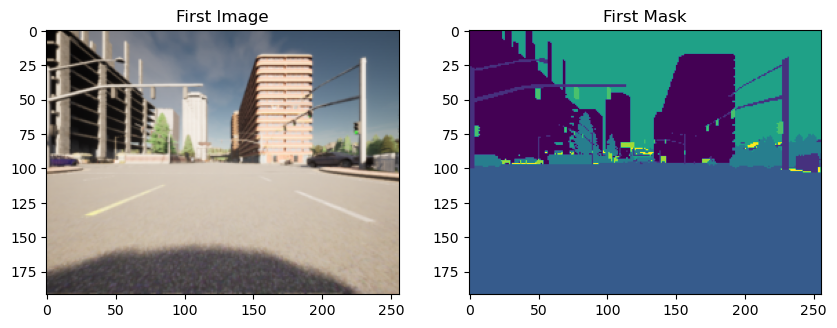

In [41]:

first_batch = next(iter(train_loader))
images, masks = first_batch

# Visualize the first image and its mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0))  
plt.title('First Image')

plt.subplot(1, 2, 2)
plt.imshow(masks[0])  
plt.title('First Mask')

plt.show()

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

We recommend using the cross entropy loss and the Adam optimizer.

In [27]:
criterion = nn.CrossEntropyLoss()

In [28]:
optimizer =  optim.Adam(unet.parameters(), lr = LR, betas =(B1, B2))

<a name='4'></a>
## 4 - Train the Model

Implement the `train` loop below to train the model.

In [29]:
losses = []
unet.train()
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(train_loader):
        images, masks = batch
        # N, C, H, W = masks.shape
        # masks = masks.reshape((N, H, W)).long()
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        output = unet(images)
        # print(output[0, :, 0, 0])
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()
        del output 
        torch.cuda.empty_cache()
        epoch_losses.append(loss.item())
        print(f"EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}")
    losses.append(np.mean(epoch_losses))

EPOCH#0,	 Batch#0,	 Loss:3.3050718307495117
EPOCH#0,	 Batch#1,	 Loss:3.1783082485198975
EPOCH#0,	 Batch#2,	 Loss:3.0666017532348633
EPOCH#0,	 Batch#3,	 Loss:2.976628065109253
EPOCH#0,	 Batch#4,	 Loss:2.905000925064087
EPOCH#0,	 Batch#5,	 Loss:2.8172807693481445
EPOCH#0,	 Batch#6,	 Loss:2.7515604496002197
EPOCH#0,	 Batch#7,	 Loss:2.7062227725982666
EPOCH#0,	 Batch#8,	 Loss:2.6156721115112305
EPOCH#0,	 Batch#9,	 Loss:2.5881741046905518
EPOCH#0,	 Batch#10,	 Loss:2.5295045375823975
EPOCH#0,	 Batch#11,	 Loss:2.4589030742645264
EPOCH#0,	 Batch#12,	 Loss:2.4636390209198
EPOCH#0,	 Batch#13,	 Loss:2.4083969593048096
EPOCH#0,	 Batch#14,	 Loss:2.3785083293914795
EPOCH#0,	 Batch#15,	 Loss:2.3379127979278564
EPOCH#0,	 Batch#16,	 Loss:2.304327964782715
EPOCH#0,	 Batch#17,	 Loss:2.30953049659729
EPOCH#0,	 Batch#18,	 Loss:2.2571990489959717
EPOCH#0,	 Batch#19,	 Loss:2.2377779483795166
EPOCH#0,	 Batch#20,	 Loss:2.2125418186187744
EPOCH#0,	 Batch#21,	 Loss:2.2173266410827637
EPOCH#0,	 Batch#22,	 Loss:2.

In [46]:
torch.save(unet.state_dict(),'unet.pth')
torch.save({'losses': losses } , 'unet_losses.pth')

In [29]:
unet = UNET(3,23,[32,64,128,256]).to(device)
unet.load_state_dict(torch.load('unet.pth'))

<All keys matched successfully>

In [31]:
losses = torch.load('unet_losses.pth')['losses']

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

_(The Predicted class of each pixel is the argmax of different probs assigned to that pixel)_

In [11]:
def create_mask(pred_mask):
    batch_size, class_num, height, width = pred_mask.shape
    mask = torch.argmax(pred_mask, dim=1)
    return mask

<a name='4-2'></a>
### 4.2 - Plot Loss Function

Plot the loss function value of your model in different iterations.

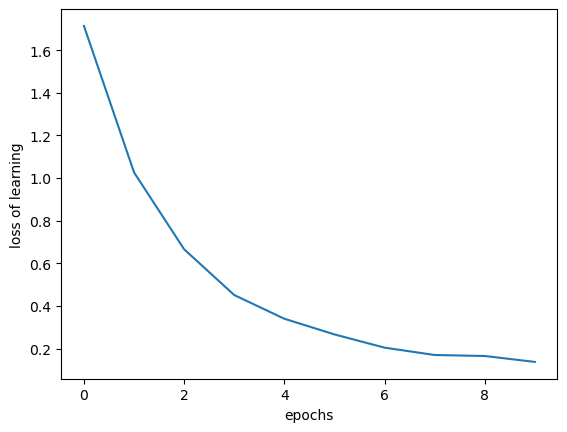

In [49]:
x = range(EPOCHS)
plt.plot(x, losses)
plt.xlabel("epochs")
plt.ylabel("loss of learning")
plt.show()

<a name='4-3'></a>
### 4.3 - mIoU

calculate mIoU for test dataset images and report average mIoU for all the images. (Remember that we have 23 classes in our dataset)

You can read about _mIoU_ metric and how it works [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). Also, there are some other good resources on _Medium_, _Wikipedia_ and etc. on this subject. Just search for **What is mIoU in semantic segmentation**.

**Important Note**: You _can_ use some helper functions from _scikit-learn_ library to calculate mIoU, but you can not use functions (from any library) that calculate mIoU or IoU directly. You need to implement the calculation of mIoU by yourself.

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix


def calculate_miou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))  
        else:
            ious.append(float(intersection) / max(union, 1))
    return np.nanmean(ious)  


In [32]:
num_classes = 23
mious = []
for i, batch in enumerate(test_loader):
  with torch.no_grad():


    images, masks = batch
    reshaped_masks = masks

    images = images.to(device)
    output = unet(images)

    output_mask = create_mask(output)
    for j in range(len(images)):
        miou = calculate_miou(reshaped_masks[j] ,output_mask.cpu()[j], num_classes)
        mious.append(miou)
        
print(f"average miou for test dataset: {sum(mious) / len(mious)}")


average miou for test dataset: 0.5621633220243023


<a name='4-3'></a>
### 4.5 - Show Predictions

Now, let's see your predictions (masks) vs ground truth masks to understand how well your model did.

In [23]:
def show_predictions(dataloader, device, model,num=1):
    """
    Displays the first image of each of the num batches
    """
    fig, axes = plt.subplots(num, 3, figsize=(15, 12))
    for i, batch in enumerate(dataloader):
        if i == num : 
            break
        image, mask = batch

        
        image = image.to(device)
        mask = mask.to(device)

        output = model.forward(image)
        pred_mask = create_mask(output)
        axes[i][0].imshow(image[0].permute(1, 2, 0).cpu().numpy())  # Convert CHW to HWC for plotting
        axes[i][0].set_title("Image")
        axes[i][0].axis('off')

        axes[i][1].imshow(mask[0].cpu().numpy())
        axes[i][1].set_title("True Mask")
        axes[i][1].axis('off')

        axes[i][2].imshow(pred_mask[0].cpu().numpy())
        axes[i][2].set_title("Predicted Mask")
        axes[i][2].axis('off')
        del output
        torch.cuda.empty_cache()
    
    plt.show()

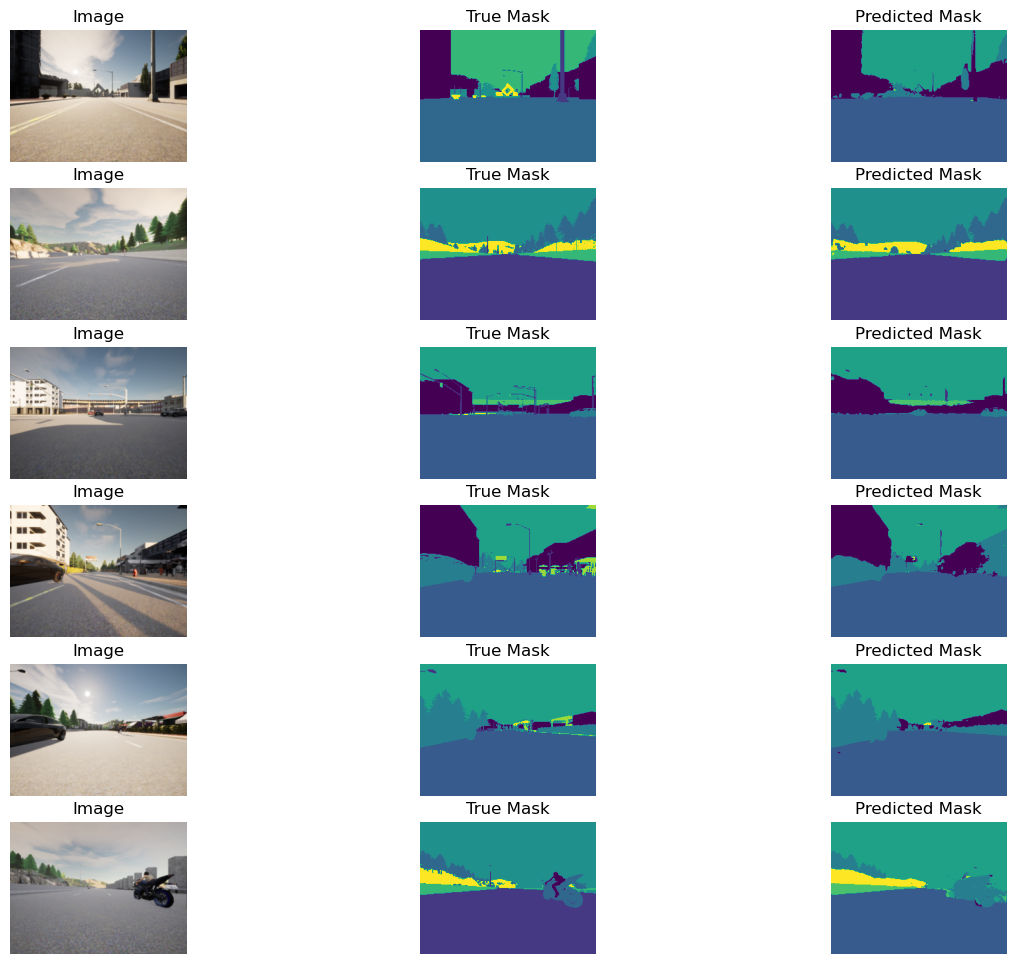

In [76]:
show_predictions(test_loader, device,unet ,6)

## 5. Making the architecture better?!

Here, we want to try to make the UNet's model architecture, better. We try an approach named __Attention UNet__. This architecture tries to focus on the important parts of the image, and ignore the rest. Using this idea, we try to make the features (in `upsampling` steps) better, to finally reach a better __Decoder__ and thus, better predictions.

## 5.1 - Attention UNet

Here, is an overview of general architecture of Attention UNet:

<img src="./Images/1.png" style="width:100%;height:auto;">

As you can see, the architecture is similar to the UNet, but with the addition of Attention Gates. These gates are used to focus on the important parts of the image, and ignore the rest. But, what are these attention gates, precisely?!

<img src="./Images/2.png" style="width:100%;height:auto;">

As you can see, the attention gate is a simple architecture, which uses the features from the encoder, and the features from the decoder, adds them and also uses residual connections to output $\hat{x_l}$. Please note that $W_x \in \mathbb{R}^{F_l \times F_{int}}$, $W_g \in \mathbb{R}^{F_g \times F_{int}}$ and $\Psi \in \mathbb{R}^{F_{int} \times 1}$ are linear transformations which are being computed using channel-wise $1 \times 1 \times 1$ convolutions for the input tensors. In other contexts, this is called _vector concatenation-based attention_, where the concatenated features $x^l$ and $g$ are linearly mapped into a $\mathbb{R}^F_{int}$ dimensional _intermediate_ space.

Let's design the `AttentionBlock` class, which will be used in the `AttentionUNet` model:

In [15]:
class AttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(AttentionBlock, self).__init__()
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            # nn.BatchNorm2d(F_int)
        )
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            # nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            # nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, g):
        x1 = self.W_x(x)
        g1 = self.W_g(g)
        psi = self.relu(x1 + g1)
        psi = self.psi(psi)
        return x * psi





You can define new `conv_block` and `upsample_block` to meet the requirements of the `AttentionUNet` model. If your previous `conv_block` and `upsample_block` functions are compatible, you can just use them!

In [16]:
class NewUp(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
        self.attention = AttentionBlock(F_l=out_channels, F_int=in_channels, F_g=in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x2 = self.attention(x2, x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [19]:
class UNet_With_Attention(nn.Module):
    def __init__(self, n_channels=3, n_classes=23,feature_sizes=[64, 128, 256, 512],dropout_prob = 0.0):
        super(UNet_With_Attention, self).__init__()
        self.upsample_layers = nn.ModuleList()
        self.downsample_layers = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        in_channels = n_channels
        for feature_size in feature_sizes:
            self.downsample_layers.append(DownSample(in_channels, feature_size, dropout_prob))
            in_channels = feature_size

        for feature_size in reversed(feature_sizes):
            self.upsample_layers.append(NewUp(2 * feature_size, feature_size))

        self.bottleneck = DoubleConv(feature_sizes[-1], feature_sizes[-1] * 2)
        self.final_conv = nn.Conv2d(feature_sizes[0], n_classes,kernel_size =1 )

    def forward(self, x):

        skip_connections = []

        for downsample in self.downsample_layers:
            conv_output, x = downsample(x)
            skip_connections.append(conv_output)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i, upsample in enumerate(self.upsample_layers):
            x = upsample(x, skip_connections[i])

        logits = self.final_conv(x)
        
        return logits

In [71]:
unet_with_attention = UNet_With_Attention(3,23,[32,64,128,256]).to(device)
summary(unet_with_attention, (3, 192, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             864
       BatchNorm2d-2         [-1, 32, 192, 256]              64
              ReLU-3         [-1, 32, 192, 256]               0
            Conv2d-4         [-1, 32, 192, 256]           9,216
       BatchNorm2d-5         [-1, 32, 192, 256]              64
              ReLU-6         [-1, 32, 192, 256]               0
        DoubleConv-7         [-1, 32, 192, 256]               0
         MaxPool2d-8          [-1, 32, 96, 128]               0
          Identity-9          [-1, 32, 96, 128]               0
       DownSample-10  [[-1, 32, 192, 256], [-1, 32, 96, 128]]               0
           Conv2d-11          [-1, 64, 96, 128]          18,432
      BatchNorm2d-12          [-1, 64, 96, 128]             128
             ReLU-13          [-1, 64, 96, 128]               0
           Conv2d-14     

In [ ]:
optimizer = optim.Adam(unet_with_attention.parameters(), lr=LR, betas=(B1, B2))
criterion = nn.CrossEntropyLoss()

Now, let's implement the training loop for our `Unet with Attention` model. (If you implemented a `train` function for previous part, you can simply reuse it here! If not, you can simply re-implement the loop)

In [72]:
losses = []

for epoch in range(EPOCHS):
    unet_with_attention.train()
    epoch_losses = []
    for i, batch in enumerate(train_loader):
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        output = unet_with_attention(images)
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()
        del output
        torch.cuda.empty_cache()
        epoch_losses.append(loss.item())



        print(f"EPOCH#{epoch},\t Batch#{i},\t Loss:{loss.item()}")
    losses.append(np.mean(epoch_losses))

EPOCH#0,	 Batch#0,	 Loss:3.218721389770508
EPOCH#0,	 Batch#1,	 Loss:3.0344467163085938
EPOCH#0,	 Batch#2,	 Loss:2.8857743740081787
EPOCH#0,	 Batch#3,	 Loss:2.767606735229492
EPOCH#0,	 Batch#4,	 Loss:2.68778133392334
EPOCH#0,	 Batch#5,	 Loss:2.5909743309020996
EPOCH#0,	 Batch#6,	 Loss:2.527282953262329
EPOCH#0,	 Batch#7,	 Loss:2.4642252922058105
EPOCH#0,	 Batch#8,	 Loss:2.3724594116210938
EPOCH#0,	 Batch#9,	 Loss:2.3412892818450928
EPOCH#0,	 Batch#10,	 Loss:2.2796809673309326
EPOCH#0,	 Batch#11,	 Loss:2.256444215774536
EPOCH#0,	 Batch#12,	 Loss:2.1886560916900635
EPOCH#0,	 Batch#13,	 Loss:2.1492388248443604
EPOCH#0,	 Batch#14,	 Loss:2.1202304363250732
EPOCH#0,	 Batch#15,	 Loss:2.104687452316284
EPOCH#0,	 Batch#16,	 Loss:2.0635297298431396
EPOCH#0,	 Batch#17,	 Loss:2.0388457775115967
EPOCH#0,	 Batch#18,	 Loss:2.01820969581604
EPOCH#0,	 Batch#19,	 Loss:1.9842976331710815
EPOCH#0,	 Batch#20,	 Loss:1.9706734418869019
EPOCH#0,	 Batch#21,	 Loss:1.9538480043411255
EPOCH#0,	 Batch#22,	 Loss:1.9

In [79]:
torch.save(unet_with_attention.state_dict(),'unet_attention.pth')
torch.save({'losses': losses } , 'unet_attention_losses.pth')


In [20]:
unet_with_attention = UNet_With_Attention(3,23,[32,64,128,256]).to(device)
unet_with_attention.load_state_dict(torch.load('unet_attention.pth'))

<All keys matched successfully>

In [26]:
losses = torch.load('unet_attention_losses.pth')['losses']

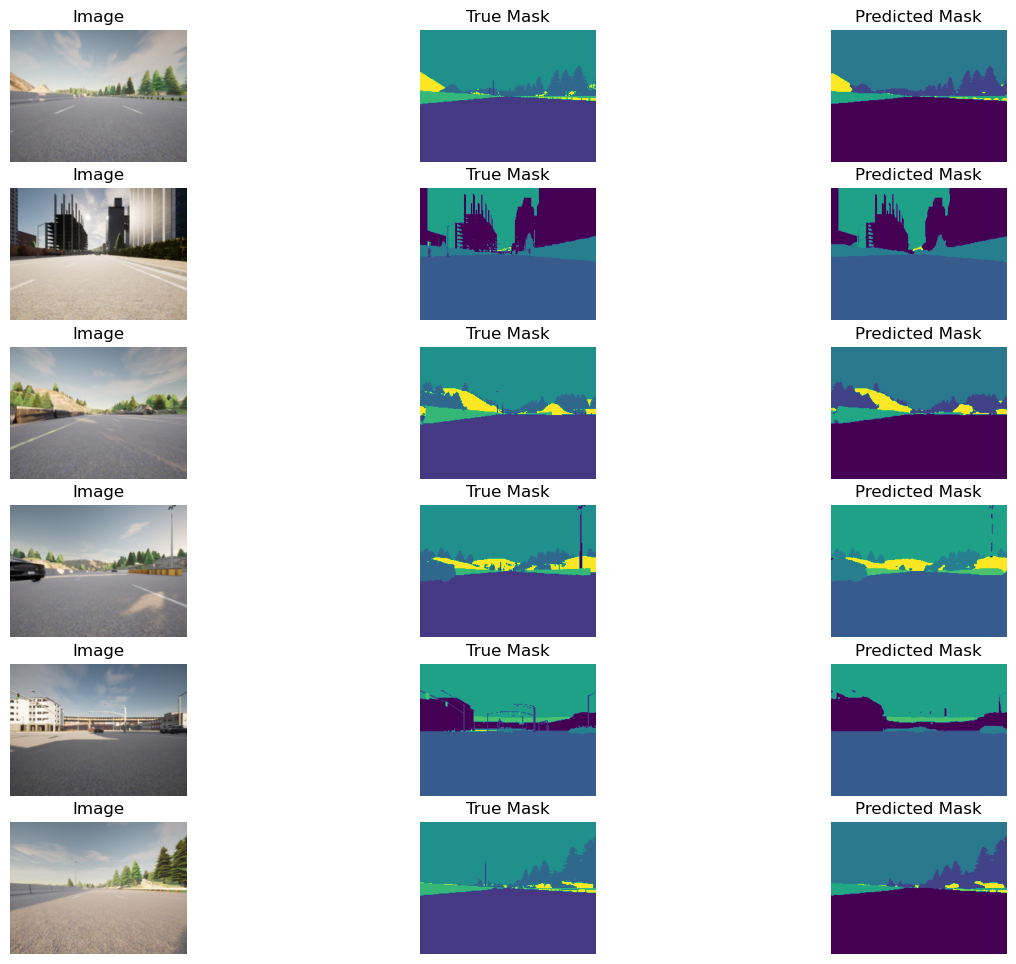

In [36]:
show_predictions(test_loader, device,unet_with_attention ,6)

Now, let's plot the `losses` vs `epochs` for the `AttentionUNet` model.

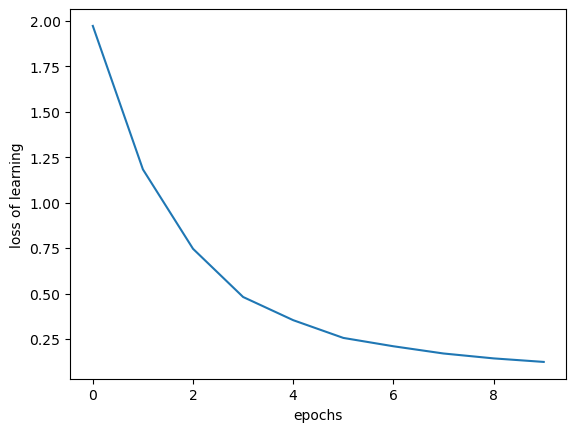

In [27]:
x = range(EPOCHS)
plt.plot(x, losses)
plt.xlabel("epochs")
plt.ylabel("loss of learning")
plt.show()

<a name='5-2'></a>
### 5.2 - mIoU

calculate mIoU for test dataset images with new model using the defined function above and report average mIoU for all the images.

In [28]:
num_classes = 23
mious = []
for i, batch in enumerate(test_loader):
  with torch.no_grad():
    # TODO: pass images from test dataloader to the model
    # and get the predictions. Then calculate the mious
    # and finally, report the average miou for the test dataset

    images, masks = batch

    reshaped_masks = masks

    images = images.to(device)

    output = unet_with_attention(images)

    output_mask = create_mask(output)
    for j in range(len(images)):
        miou = calculate_miou(reshaped_masks[j] ,output_mask.cpu()[j], num_classes)
        mious.append(miou)

print(f"average miou for test dataset: {sum(mious) / len(mious)}")


average miou for test dataset: 0.5825350987784464


### 5.3
Compare the results between `Unet` and `AttentionUNet` models. Do your comparison in terms of `mIoU` and `loss` values, and also the `training time`. Which one is better in each of these metrics? Explain your answer based on the outputs and plots and loss values and mIoU values.

### Loss and mIoU Comparison

Accurately predicting small objects in segmentation tasks is challenging due to their significant shape variability. Traditional approaches often involve separating the localization and subsequent segmentation steps to improve accuracy. However, this can be effectively achieved by incorporating attention gates (AGs) within the Attention U-Net architecture.

**Role of Attention Gates in Attention U-Net**:

- **Selective Focus**: AGs enable the network to focus selectively on relevant features while ignoring irrelevant ones. This selective focus helps in better localization and segmentation of small objects.
- **Efficient Weight Alignment**: AGs align the weights of the input feature maps, making relevant features more prominent and suppressing irrelevant ones. This alignment occurs through a series of ReLU activations, convolutional layers, and sigmoid functions.
- **Normalized Output**: The output of AGs is a number between 0 and 1, where values closer to 1 indicate more relevant features. This normalization helps the model to prioritize important features during training.

**Benefits of Attention U-Net**:

- **Reduced Computational Waste**: By highlighting relevant activations, AGs reduce the computational resources wasted on processing irrelevant features, leading to more efficient training.
- **Improved Generalization**: The selective focus mechanism provides better generalization power, allowing the model to perform well on both training and unseen test data.

**Performance Metrics**:

- **Lower Final Loss**: Attention U-Net consistently achieves a lower final loss compared to the standard U-Net, indicating better optimization during training.
- **Higher mIoU**: The Mean Intersection over Union (mIoU) metric is significantly improved with Attention U-Net. This metric reflects the accuracy of segmentation, with higher values indicating better performance.

Analyzing the results of training both U-Net and Attention U-Net models, it is evident that the Attention U-Net reaches a smaller final loss and achieves a higher mIoU, proving its superior performance on both training and test datasets.

### Training Time Comparison

While Attention U-Net offers improved accuracy and better segmentation performance, it comes with a trade-off in terms of training time and resource usage.

**Resource Requirements**:

- **Extra Convolutional Layers and Activation Functions**: The addition of AGs introduces extra convolutional layers and activation functions. These layers require more computational power and memory, increasing the overall resource requirements.
- **Longer Training Time**: The increased complexity of the network due to AGs leads to a longer training time. Training an Attention U-Net model typically takes more epochs to converge compared to a standard U-Net.

**GPU Utilization**:

- **Higher GPU Usage**: The additional layers and operations in AGs result in higher GPU utilization. This is necessary to handle the increased computational load, especially when working with large datasets or high-resolution images.

Despite the increased training time and resource usage, the benefits of improved segmentation accuracy and better generalization make Attention U-Net a valuable choice for many applications. The trade-off is often considered worthwhile in scenarios where precision is critical, such as medical imaging, autonomous driving, and other advanced computer vision tasks.
